# Neuron Alignment + REPAIR + Adversarial robustness + MTD

* The code in this notebook uses Jordan Keller's code to align models and apply REPAIR: https://github.com/KellerJordan/REPAIR.git
  - https://github.com/KellerJordan/REPAIR/blob/master/notebooks/Train-and-Permute-MNIST-MLP-BatchNorm.ipynb

* `torchattacks` library is used for the implementation of adversarial attacks: https://github.com/Harry24k/adversarial-attacks-pytorch.git

# Imports and helpful functions

In [ ]:
!pip install git+https://github.com/Harry24k/adversarial-attacks-pytorch.git

In [3]:
import math
import random
import scipy

import torch
from torch import nn, Tensor

from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam, lr_scheduler
import torchvision
import torchvision.transforms as T

from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor, Lambda, Compose, RandomRotation, Resize, Grayscale
import matplotlib.pyplot as plt
from torch.nn.parameter import Parameter, UninitializedParameter
import torch.nn.functional as F
from torch.nn.modules.module import Module
from torch.nn import init
from tqdm.notebook import trange, tqdm
import torchvision.transforms.functional as TF
from typing import Optional, List, Tuple, Union
from torch.nn.common_types import _size_1_t, _size_2_t, _size_3_t
import itertools
import numpy as np

import torchattacks

import copy
import io
import os

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [5]:
os.makedirs('./mlps3', exist_ok=True)
def save_model(model, i):
    sd = model.state_dict()
    torch.save(model.state_dict(), 'mlps3/%s.pt' % i)

def load_model(model, i):
    sd = torch.load('mlps3/%s.pt' % i)
    model.load_state_dict(sd)

In [6]:
class Clamp(object):
  def __init__(self):
    pass
  def __call__(self, sample):
        return torch.clamp(sample, 0,1)


def load_data(split, dataset_name, datadir, nchannels):
    ## https://gist.github.com/weiaicunzai/e623931921efefd4c331622c344d8151
    if dataset_name == 'MNIST':
        normalize = transforms.Normalize(mean=[0.1307], std=[0.3081])
    elif dataset_name == 'SVHN':
        # normalize = transforms.Normalize(mean=[0.4377, 0.4438, 0.4728], std=[0.1980, 0.2010, 0.1970])
        normalize = transforms.Normalize(mean=[0.4377], std=[0.1980])
    elif dataset_name == 'CIFAR10':
        normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
    elif dataset_name == 'CIFAR100':
        normalize = transforms.Normalize(mean=[0.5071, 0.4865, 0.4409], std=[0.2673, 0.2564, 0.2762])
    elif dataset_name == 'imagenet':
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    if dataset_name == 'imagenet':
        tr_transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224),
                                           transforms.RandomHorizontalFlip(), transforms.ToTensor(), normalize])
        val_transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224),
                                           transforms.RandomHorizontalFlip(), transforms.ToTensor(), normalize])
    elif dataset_name == 'SVHN':
        tr_transform = transforms.Compose([transforms.Resize(32), transforms.Grayscale(), transforms.ToTensor(), normalize, Clamp(),])
        val_transform = transforms.Compose([transforms.Resize(32), transforms.Grayscale(), transforms.ToTensor(), normalize, Clamp()])
    elif dataset_name == 'GTSRB':
        tr_transform = transforms.Compose([transforms.Resize(42), transforms.Grayscale(), transforms.CenterCrop(32), transforms.ToTensor()])
        val_transform = transforms.Compose([transforms.Resize(42), transforms.Grayscale(), transforms.CenterCrop(32), transforms.ToTensor()])
    else:
        tr_transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor(), normalize])
        val_transform = transforms.Compose([transforms.Resize(32), transforms.ToTensor(), normalize])

    get_dataset = getattr(datasets, dataset_name)
    if dataset_name == 'SVHN':
        if split == 'train':
            dataset = get_dataset(root=datadir, split='train', download=True, transform=tr_transform)
        else:
            dataset = get_dataset(root=datadir, split='test', download=True, transform=val_transform)
    elif dataset_name == 'GTSRB':
        if split == 'train':
            dataset = datasets.GTSRB(root=datadir, split='train', download=True, transform=tr_transform)
        else:
            dataset = datasets.GTSRB(root=datadir, split='test', download=True, transform=tr_transform)
    else:
        if split == 'train':
            dataset = get_dataset(root=datadir, train=True, download=True, transform=tr_transform)
        else:
            dataset = get_dataset(root=datadir, train=False, download=True, transform=val_transform)

    return dataset

In [7]:
# GTSRB
batch_size = 256
nchannels = 1
train_dataset = load_data("train", "GTSRB", "datasets", nchannels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = load_data("test", "GTSRB", "datasets", nchannels)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 187490228/187490228 [00:06<00:00, 27090442.64it/s]


Extracting datasets/gtsrb/GTSRB-Training_fixed.zip to datasets/gtsrb


100%|██████████| 88978620/88978620 [00:03<00:00, 24207178.74it/s]


Extracting datasets/gtsrb/GTSRB_Final_Test_Images.zip to datasets/gtsrb


100%|██████████| 99620/99620 [00:00<00:00, 328176.97it/s]

Extracting datasets/gtsrb/GTSRB_Final_Test_GT.zip to datasets/gtsrb


Shape of X [N, C, H, W]:  torch.Size([256, 1, 32, 32])
Shape of y:  torch.Size([256]) torch.int64
tensor(25)
tensor(1.)
tensor(0.0196)


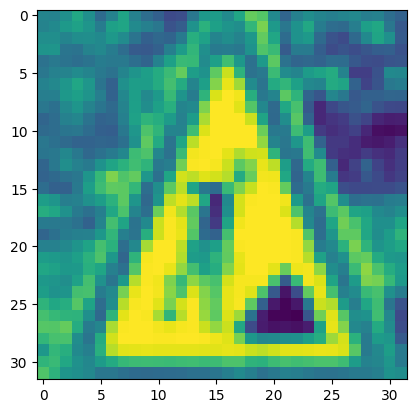

In [8]:
for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

X = X.permute(0,2,3,1)
plt.imshow(X[8,:,:,:])
print(y[8])
# print(X[8,:,:,:])
print(torch.max(X[:,:,:,:]))
print(torch.min(X[:,:,:,:]))

In [9]:
# evaluates accuracy
def evaluate(model, loader=test_dataloader):
    model.eval()
    correct = 0
    with torch.no_grad(), autocast():
        for inputs, labels in loader:
            outputs = model(inputs.cuda())
            pred = outputs.argmax(dim=1)
            correct += (labels.cuda() == pred).sum().item()
    return correct

# evaluates acc and loss
def evaluate2(model, loader=test_dataloader):
    model.eval()
    losses = []
    correct = 0
    total = 0
    with torch.no_grad(), autocast():
        for inputs, labels in loader:
            outputs = model(inputs.cuda())
            pred = outputs.argmax(dim=1)
            correct += (labels.cuda() == pred).sum().item()
            total += len(labels)
            loss = F.cross_entropy(outputs, labels.cuda())
            losses.append(loss.item())
    return correct / total, np.array(losses).mean()

def full_eval1(model):
    tr_acc, tr_loss = evaluate2(model, loader=train_dataloader)
    te_acc, te_loss = evaluate2(model, loader=test_dataloader)
    return '%.2f, %.3f, %.2f, %.3f' % (100*tr_acc, tr_loss, 100*te_acc, te_loss)

def full_eval(model):
    tr_acc, tr_loss = evaluate2(model, loader=train_dataloader)
    te_acc, te_loss = evaluate2(model, loader=test_dataloader)
    return (100*tr_acc, tr_loss, 100*te_acc, te_loss)

## Models



In [10]:
import torch.nn as nn
import torch.nn.functional as F

class NormMLP(nn.Module):
    def __init__(self, h=128, layers=3):
        super().__init__()
        self.fc1 = nn.Linear(32*32, h, bias=False)
        self.bn1 = nn.BatchNorm1d(h)
        mid_layers = []
        for _ in range(layers):
            mid_layers.extend([
                nn.Linear(h, h, bias=False),
                nn.BatchNorm1d(h),
                nn.ReLU(),
            ])
        self.layers = nn.Sequential(*mid_layers)
        self.fc2 = nn.Linear(h, 43)

    def forward(self, x):
        if x.size(1) == 3:
            x = x.mean(1, keepdim=True)
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.layers(x)
        x = self.fc2(x)
        return x

class MLP(nn.Module):
    def __init__(self, h=128, layers=3):
        super().__init__()
        self.fc1 = nn.Linear(32*32, h)
        mid_layers = []
        for _ in range(layers):
            mid_layers.extend([nn.Linear(h, h), nn.ReLU()])
        self.layers = nn.Sequential(*mid_layers)
        self.fc2 = nn.Linear(h, 43)

    def forward(self, x):
        if x.size(1) == 3:
            x = x.mean(1, keepdim=True)
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.layers(x)
        x = self.fc2(x)
        return x

def fuse_fc_bn(fc, bn):
    fused = nn.Linear(fc.in_features, fc.out_features)
    # setting weights
    w_fc = fc.weight.clone()
    bn_std = (bn.eps + bn.running_var).sqrt()
    gamma = bn.weight / bn_std
    fused.weight.data = (w_fc * gamma.reshape(-1, 1))
    # setting bias
    b_fc = fc.bias if fc.bias is not None else torch.zeros_like(bn.bias)
    beta = bn.bias + gamma * (-bn.running_mean + b_fc)
    fused.bias.data = beta
    return fused

def fuse_net(net):
    assert isinstance(net, NormMLP)
    layers = len(net.layers)//3
    h = len(net.fc1.weight)
    net1 = MLP(h, layers)
    net1.fc1 = fuse_fc_bn(net.fc1, net.bn1)
    for i in range(layers):
        net1.layers[2*i] = fuse_fc_bn(net.layers[3*i], net.layers[3*i+1])
    net1.fc2.load_state_dict(net.fc2.state_dict())
    return net1

# Train and save two models

In [11]:
def train(save_key, layers=5, h=512):
    model = NormMLP(h=h, layers=layers).cuda()

    optimizer = SGD(model.parameters(), lr=0.05, momentum=0.9)

    EPOCHS = 50
    ne_iters = len(train_dataloader)
    lr_schedule = np.interp(np.arange(1+EPOCHS*ne_iters), [0, 5*ne_iters, EPOCHS*ne_iters], [0, 1, 0])
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_schedule.__getitem__)

    scaler = GradScaler()
    loss_fn = CrossEntropyLoss()

    for _ in tqdm(range(EPOCHS)):
        model.train()
        for i, (inputs, labels) in enumerate(train_dataloader):
            optimizer.zero_grad(set_to_none=True)
            with autocast():
                outputs = model(inputs.cuda())
                loss = loss_fn(outputs, labels.cuda())
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

    print(evaluate(model))
    save_model(model, save_key)

In [13]:
layers = 1
h = 256
train('mlp_e50_l%d_h%d_A' % (layers, h), layers=layers, h=h)
train('mlp_e50_l%d_h%d_B' % (layers, h), layers=layers, h=h)
train('mlp_e50_l%d_h%d_C' % (layers, h), layers=layers, h=h)
train('mlp_e50_l%d_h%d_D' % (layers, h), layers=layers, h=h)

  0%|          | 0/50 [00:00<?, ?it/s]

10755


  0%|          | 0/50 [00:00<?, ?it/s]

10802


  0%|          | 0/50 [00:00<?, ?it/s]

10736


  0%|          | 0/50 [00:00<?, ?it/s]

10822


# Matching code

In [16]:
# given two networks net0, net1 which each output a feature map of shape NxCxWxH
# this will reshape both outputs to (N*W*H)xC
# and then compute a CxC correlation matrix between the outputs of the two networks
def run_corr_matrix(net0, net1, epochs=1, loader=train_dataloader):
    n = epochs*len(loader)
    mean0 = mean1 = std0 = std1 = None
    with torch.no_grad():
        net0.eval()
        net1.eval()
        for _ in range(epochs):
            for i, (images, _) in enumerate(tqdm(loader)):
                img_t = images.float().cuda()
                out0 = net0(img_t)
                out0 = out0.reshape(out0.shape[0], out0.shape[1], -1).permute(0, 2, 1)
                out0 = out0.reshape(-1, out0.shape[2]).double()

                out1 = net1(img_t)
                out1 = out1.reshape(out1.shape[0], out1.shape[1], -1).permute(0, 2, 1)
                out1 = out1.reshape(-1, out1.shape[2]).double()

                mean0_b = out0.mean(dim=0)
                mean1_b = out1.mean(dim=0)
                std0_b = out0.std(dim=0)
                std1_b = out1.std(dim=0)
                outer_b = (out0.T @ out1) / out0.shape[0]

                if i == 0:
                    mean0 = torch.zeros_like(mean0_b)
                    mean1 = torch.zeros_like(mean1_b)
                    std0 = torch.zeros_like(std0_b)
                    std1 = torch.zeros_like(std1_b)
                    outer = torch.zeros_like(outer_b)
                mean0 += mean0_b / n
                mean1 += mean1_b / n
                std0 += std0_b / n
                std1 += std1_b / n
                outer += outer_b / n

    cov = outer - torch.outer(mean0, mean1)
    corr = cov / (torch.outer(std0, std1) + 1e-4)
    return corr

In [17]:
def get_layer_perm1(corr_mtx):
    corr_mtx_a = corr_mtx.cpu().numpy()
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(corr_mtx_a, maximize=True)
    assert (row_ind == np.arange(len(corr_mtx_a))).all()
    perm_map = torch.tensor(col_ind).long()
    return perm_map

# returns the channel-permutation to make layer1's activations most closely
# match layer0's.
def get_layer_perm(net0, net1):
    corr_mtx = run_corr_matrix(net0, net1)
    return get_layer_perm1(corr_mtx)

# Find neuron-permutation for each layer

In [33]:
layers=1
h = 256

model0 = NormMLP(h=h, layers=layers).cuda()
model1 = NormMLP(h=h, layers=layers).cuda()
load_model(model0, 'mlp_e50_l%d_h%d_U' % (layers, h))
load_model(model1, 'mlp_e50_l%d_h%d_D' % (layers, h))

class Subnet(nn.Module):
        def __init__(self, model, layer_i):
            super().__init__()
            self.model = model
            self.layer_i = layer_i
        def forward(self, x):
            if x.size(1) == 3:
                x = x.mean(1, keepdim=True)
            x = x.reshape(x.size(0), -1)
            x = F.relu(self.model.bn1(self.model.fc1(x)))
            x = self.model.layers[:3*self.layer_i](x)
            return x

perm_map = get_layer_perm(Subnet(model0, layer_i=0), Subnet(model1, layer_i=0))
fc = model1.fc1
w_list = [fc.weight]
bn = model1.bn1
w_list.extend([bn.weight,
                    bn.bias,
                    bn.running_mean,
                    bn.running_var])
for w in w_list:
        w.data = w[perm_map]
for w in [model1.layers[0].weight]:
        w.data = w.data[:, perm_map]

########

for i in range(layers):
        perm_map = get_layer_perm(Subnet(model0, layer_i=i+1), Subnet(model1, layer_i=i+1))
        fc = model1.layers[3*i]
        w_list = [fc.weight]
        bn = model1.layers[3*i+1]
        w_list.extend([bn.weight,
                        bn.bias,
                        bn.running_mean,
                        bn.running_var])
        for w in w_list:
            w.data = w[perm_map]
        if i < layers-1:
            for w in [model1.layers[3*(i+1)].weight]:
                w.data = w[:, perm_map]
w = model1.fc2.weight
w.data = w[:, perm_map]

save_model(model1, 'mlp_e50_l%d_h%d_D_perm_U' % (layers, h))

  0%|          | 0/105 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?it/s]

# Evaluate the interpolated network

In [19]:
def mix_weights(model, alpha, key0, key1, premodel=None):
    sd0 = torch.load('mlps3/%s.pt' % key0)
    sd1 = torch.load('mlps3/%s.pt' % key1)
    sd_alpha = {k: (1 - alpha) * sd0[k].cuda() + alpha * sd1[k].cuda()
                for k in sd0.keys()}
    model.load_state_dict(sd_alpha)

# use the train loader with data augmentation as this gives better results
def reset_bn_stats(model, epochs=2, loader=train_dataloader):
    # resetting stats to baseline first as below is necessary for stability
    for m in model.modules():
        if isinstance(m, nn.modules.batchnorm._BatchNorm):
            m.momentum = None # use simple average
            m.reset_running_stats()
    # run a single train epoch with augmentations to recalc stats
    model.train()
    for _ in range(epochs):
        with torch.no_grad(), autocast():
            for images, _ in loader:
                output = model(images.cuda())
    model.eval()

In [34]:
layers = 1
h = 256
pre = 'mlp_e50_l%d_h%d' % (layers, h)
k1 = '%s_U' % pre
k2 = '%s_D_perm_U' % pre

model0 = NormMLP(h, layers).cuda()
model1 = NormMLP(h, layers).cuda()
load_model(model0, k1)
load_model(model1, k2)
print('(α=0.0)', full_eval(model0))
print('(α=1.0)', full_eval(model1))

model_a = NormMLP(h, layers).cuda()
mix_weights(model_a, 0.5, k1, k2)
reset_bn_stats(model_a)
print('(α=0.5 permuted corrected)', full_eval(model_a))
save_model(model_a, 'mlp_e50_l%d_h%d_V' % (layers, h))

(α=0.0) (96.23498498498499, 0.12393399019326483, 80.81551860649247, 0.8909388792514801)
(α=1.0) (99.81981981981983, 0.01470215656306772, 85.6848772763262, 0.8646173292398452)
(α=0.5 permuted corrected) (96.49024024024024, 0.12249917026076998, 81.37767220902613, 0.883925234079361)


# Attacks

##Static ensembles

In [35]:
def attack_with_torchattacks(model, attack, xline, dataloader):
    print(f'Testing {attack} attack on ensemble')

    model.eval().to(device)
    acc_list = []

    for k, x in enumerate(xline):
      eps = Tensor([x]).to(device)
      sum_correct = 0

      for i, (data, target) in enumerate(dataloader):
          data, target = data.to(device), target.to(device)

          ## attacks: https://arxiv.org/pdf/2010.01950.pdf
          if attack=="FGSM":
              atk = torchattacks.FGSM(model, eps=eps)
          elif attack == "PGD":
              atk = torchattacks.PGD(model, eps=eps, alpha=4/255, steps=2, random_start=False)
          adversarial_examples = atk(data, target)

          # Re-classify the perturbed image
          output = model(adversarial_examples)
          final_pred = output.max(1)[1]  # get the index of the max log-probability
          correct = final_pred.eq(target).sum().item()

          sum_correct += correct

      accuracy = sum_correct / len(dataloader.dataset)
      print(f'Test {k + 1}, accuracy={accuracy}')
      acc_list.append(accuracy)

    return acc_list

[(0.0, 0.0, 0.5, 1.0), (0.0, 0.06470588235294118, 1.0, 1.0), (0.0, 0.6450980392156863, 1.0, 1.0), (0.24984187223276405, 1.0, 0.717900063251107, 1.0), (0.7179000632511068, 1.0, 0.2498418722327641, 1.0), (1.0, 0.7269426289034134, 0.0, 1.0), (1.0, 0.18954248366013093, 0.0, 1.0), (0.5, 0.0, 0.0, 1.0)]
A
Testing FGSM attack on ensemble
Test 1, accuracy=0.8517022961203484
Test 2, accuracy=0.6694378463974664
Test 3, accuracy=0.49263657957244655
Test 4, accuracy=0.37252573238321457
Test 5, accuracy=0.29382422802850355
P
Testing FGSM attack on ensemble
Test 1, accuracy=0.8309580364212193
Test 2, accuracy=0.6463974663499604
Test 3, accuracy=0.4741884402216944
Test 4, accuracy=0.36001583531274745
Test 5, accuracy=0.27949326999208235
Q
Testing FGSM attack on ensemble
Test 1, accuracy=0.8134600158353128
Test 2, accuracy=0.6330958036421219
Test 3, accuracy=0.48091844813935075
Test 4, accuracy=0.36706254948535233
Test 5, accuracy=0.2880443388756928
R
Testing FGSM attack on ensemble
Test 1, accuracy=0

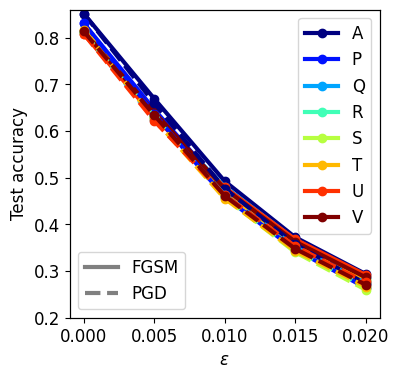

In [36]:
from matplotlib import cm

layers = 1
h=256

colors = [ cm.jet(x) for x in np.linspace(0, 1, 8) ]
print(colors)
xline = np.linspace(0.0, 0.02, 5)

mnames = ['A', 'P', 'Q', 'R', 'S', 'T', 'U', 'V']
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize=12)

fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot(111)

for mn, cn in zip(mnames, colors):
    print(mn)
    model0 = NormMLP(h, layers).cuda()
    load_model(model0, 'mlp_e50_l%d_h%d_%s' % (layers, h, mn))
    acc_list_1 = attack_with_torchattacks(model0, "FGSM", xline, test_dataloader)
    ax.plot(xline, acc_list_1, f'-o', label=f"{mn}", lw=3, color=cn)

for mn, cn in zip(mnames, colors):
    print(mn)
    model0 = NormMLP(h, layers).cuda()
    load_model(model0, 'mlp_e50_l%d_h%d_%s' % (layers, h, mn))
    acc_list_2 = attack_with_torchattacks(model0, "PGD", xline, test_dataloader)
    ax.plot(xline, acc_list_2, f'--o', lw=3, color=cn)

ax2 = ax.twinx()
ax2.plot(0, -1, f'-', color='grey', lw=3, label='FGSM')
ax2.plot(0, -1, f'--', color='grey', lw=3, label='PGD')
ax2.get_yaxis().set_visible(False)

ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('Test accuracy')
ax.set_ylim([0.2,0.86])
ax.legend(loc=1)
ax2.legend(loc=3)
plt.show()

## Dynamic ensembles

In [39]:
def attack_with_torchattacks_endpoints(model, endpoint, attack, xline, dataloader):
    print(f'Testing {attack} attack on ensemble')

    model.eval().to(device)
    acc_list = []

    for k, x in enumerate(xline):
      eps = Tensor([x]).to(device)
      sum_correct = 0

      for i, (data, target) in enumerate(dataloader):
          data, target = data.to(device), target.to(device)

          ## attacks: https://arxiv.org/pdf/2010.01950.pdf
          if attack=="FGSM":
              atk = torchattacks.FGSM(endpoint, eps=eps)
          elif attack == "PGD":
              atk = torchattacks.PGD(endpoint, eps=eps, alpha=4/255, steps=2, random_start=False)
          adversarial_examples = atk(data, target)

          # Re-classify the perturbed image
          output = model(adversarial_examples)
          final_pred = output.max(1)[1]  # get the index of the max log-probability
          correct = final_pred.eq(target).sum().item()

          sum_correct += correct

      accuracy = sum_correct / len(dataloader.dataset)
      print(f'Test {k + 1}, accuracy={accuracy}')
      acc_list.append(accuracy)

    return acc_list

[(0.0, 0.0, 0.5, 1.0), (0.0, 0.06470588235294118, 1.0, 1.0), (0.0, 0.6450980392156863, 1.0, 1.0), (0.24984187223276405, 1.0, 0.717900063251107, 1.0), (0.7179000632511068, 1.0, 0.2498418722327641, 1.0), (1.0, 0.7269426289034134, 0.0, 1.0), (1.0, 0.18954248366013093, 0.0, 1.0), (0.5, 0.0, 0.0, 1.0)]
A
Testing FGSM attack on ensemble
Test 1, accuracy=0.8517022961203484
Test 2, accuracy=0.6694378463974664
Test 3, accuracy=0.49263657957244655
Test 4, accuracy=0.37252573238321457
Test 5, accuracy=0.29382422802850355
P
Testing FGSM attack on ensemble
Test 1, accuracy=0.8309580364212193
Test 2, accuracy=0.6795724465558195
Test 3, accuracy=0.5295328582739509
Test 4, accuracy=0.42264449722882025
Test 5, accuracy=0.34576405384006337
Q
Testing FGSM attack on ensemble
Test 1, accuracy=0.8134600158353128
Test 2, accuracy=0.6776722090261282
Test 3, accuracy=0.543230403800475
Test 4, accuracy=0.4478226444972288
Test 5, accuracy=0.3695961995249406
R
Testing FGSM attack on ensemble
Test 1, accuracy=0.81

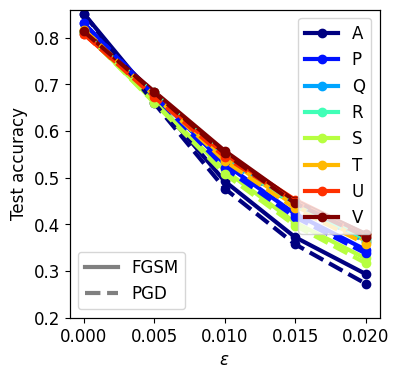

In [40]:
from matplotlib import cm

layers = 1
h=256

colors = [ cm.jet(x) for x in np.linspace(0, 1, 8) ]
print(colors)
xline = np.linspace(0.0, 0.02, 5)

mnames = ['A', 'P', 'Q', 'R', 'S', 'T', 'U', 'V']
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize=12)

fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot(111)

model1 = NormMLP(h, layers).cuda()
load_model(model1, 'mlp_e50_l%d_h%d_A' % (layers, h))

for mn, cn in zip(mnames, colors):
    print(mn)
    model0 = NormMLP(h, layers).cuda()
    load_model(model0, 'mlp_e50_l%d_h%d_%s' % (layers, h, mn))
    acc_list_1 = attack_with_torchattacks_endpoints(model0, model1, "FGSM", xline, test_dataloader)
    ax.plot(xline, acc_list_1, f'-o', label=f"{mn}", lw=3, color=cn)

for mn, cn in zip(mnames, colors):
    print(mn)
    model0 = NormMLP(h, layers).cuda()
    load_model(model0, 'mlp_e50_l%d_h%d_%s' % (layers, h, mn))
    acc_list_2 = attack_with_torchattacks_endpoints(model0, model1, "PGD", xline, test_dataloader)
    ax.plot(xline, acc_list_2, f'--o', lw=3, color=cn)

ax2 = ax.twinx()
ax2.plot(0, -1, f'-', color='grey', lw=3, label='FGSM')
ax2.plot(0, -1, f'--', color='grey', lw=3, label='PGD')
ax2.get_yaxis().set_visible(False)

ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('Test accuracy')
ax.set_ylim([0.2,0.86])
ax.legend(loc=1)
ax2.legend(loc=3)
plt.show()

In [37]:
def attack_with_torchattacks_4_endpoints(model, e1, e2, e3, e4, attack, xline, dataloader):
    print(f'Testing {attack} attack on ensemble')

    model.eval().to(device)
    acc_list = []

    for k, x in enumerate(xline):
      eps = Tensor([x]).to(device)
      sum_correct = 0

      for i, (data, target) in enumerate(dataloader):
          data, target = data.to(device), target.to(device)

          ## attacks: https://arxiv.org/pdf/2010.01950.pdf
          if attack=="FGSM":
              atk1 = torchattacks.FGSM(e1, eps=eps)
              atk2 = torchattacks.FGSM(e2, eps=eps)
              atk3 = torchattacks.FGSM(e3, eps=eps)
              atk4 = torchattacks.FGSM(e4, eps=eps)
          elif attack == "PGD":
              atk1 = torchattacks.PGD(e1, eps=eps, alpha=4/255, steps=2, random_start=False)
              atk2 = torchattacks.PGD(e2, eps=eps, alpha=4/255, steps=2, random_start=False)
              atk3 = torchattacks.PGD(e3, eps=eps, alpha=4/255, steps=2, random_start=False)
              atk4 = torchattacks.PGD(e4, eps=eps, alpha=4/255, steps=2, random_start=False)
          adversarial_examples1 = atk1(data, target)
          adversarial_examples2 = atk2(data, target)
          adversarial_examples3 = atk3(data, target)
          adversarial_examples4 = atk4(data, target)

          # Re-classify the perturbed image
          output1 = model(adversarial_examples1)
          final_pred1 = output1.max(1)[1]  # get the index of the max log-probability
          correct1 = final_pred1.eq(target).sum().item()

          # Re-classify the perturbed image
          output2 = model(adversarial_examples2)
          final_pred2 = output2.max(1)[1]  # get the index of the max log-probability
          correct2 = final_pred2.eq(target).sum().item()

          # Re-classify the perturbed image
          output3 = model(adversarial_examples3)
          final_pred3 = output3.max(1)[1]  # get the index of the max log-probability
          correct3 = final_pred3.eq(target).sum().item()

          # Re-classify the perturbed image
          output4 = model(adversarial_examples4)
          final_pred4 = output4.max(1)[1]  # get the index of the max log-probability
          correct4 = final_pred4.eq(target).sum().item()

          sum_correct += (correct1 + correct2 + correct3 + correct4) / 4

      accuracy = sum_correct / len(dataloader.dataset)
      print(f'Test {k + 1}, accuracy={accuracy}')
      acc_list.append(accuracy)

    return acc_list

[(0.0, 0.0, 0.5, 1.0), (0.0, 0.06470588235294118, 1.0, 1.0), (0.0, 0.6450980392156863, 1.0, 1.0), (0.24984187223276405, 1.0, 0.717900063251107, 1.0), (0.7179000632511068, 1.0, 0.2498418722327641, 1.0), (1.0, 0.7269426289034134, 0.0, 1.0), (1.0, 0.18954248366013093, 0.0, 1.0), (0.5, 0.0, 0.0, 1.0)]
A
Testing FGSM attack on ensemble
Test 1, accuracy=0.8517022961203484
Test 2, accuracy=0.7063143309580364
Test 3, accuracy=0.5544338875692795
Test 4, accuracy=0.44418052256532065
Test 5, accuracy=0.36714172604908946
P
Testing FGSM attack on ensemble
Test 1, accuracy=0.8309580364212193
Test 2, accuracy=0.6893507521773555
Test 3, accuracy=0.5466745843230404
Test 4, accuracy=0.4406967537608868
Test 5, accuracy=0.3656571654790182
Q
Testing FGSM attack on ensemble
Test 1, accuracy=0.8134600158353128
Test 2, accuracy=0.6743467933491687
Test 3, accuracy=0.5420625494853524
Test 4, accuracy=0.44479414093428343
Test 5, accuracy=0.37040775930324626
R
Testing FGSM attack on ensemble
Test 1, accuracy=0.81

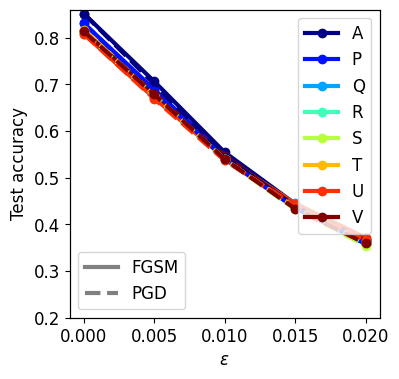

In [38]:
from matplotlib import cm

layers = 1
h=256

colors = [ cm.jet(x) for x in np.linspace(0, 1, 8) ]
print(colors)
xline = np.linspace(0.0, 0.02, 5)

mnames = ['A', 'P', 'Q', 'R', 'S', 'T', 'U', 'V']
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize=12)

fig = plt.figure(figsize=[4, 4])
ax = fig.add_subplot(111)

model1 = NormMLP(h, layers).cuda()
load_model(model1, 'mlp_e50_l%d_h%d_A' % (layers, h))
model2 = NormMLP(h, layers).cuda()
load_model(model2, 'mlp_e50_l%d_h%d_B' % (layers, h))
model3 = NormMLP(h, layers).cuda()
load_model(model3, 'mlp_e50_l%d_h%d_C' % (layers, h))
model4 = NormMLP(h, layers).cuda()
load_model(model4, 'mlp_e50_l%d_h%d_D' % (layers, h))

for mn, cn in zip(mnames, colors):
    print(mn)
    model0 = NormMLP(h, layers).cuda()
    load_model(model0, 'mlp_e50_l%d_h%d_%s' % (layers, h, mn))
    acc_list_1 = attack_with_torchattacks_4_endpoints(model0, model1, model2, model3, model4, "FGSM", xline, test_dataloader)
    ax.plot(xline, acc_list_1, f'-o', label=f"{mn}", lw=3, color=cn)

for mn, cn in zip(mnames, colors):
    print(mn)
    model0 = NormMLP(h, layers).cuda()
    load_model(model0, 'mlp_e50_l%d_h%d_%s' % (layers, h, mn))
    acc_list_2 = attack_with_torchattacks_4_endpoints(model0, model1, model2, model3, model4, "PGD", xline, test_dataloader)
    ax.plot(xline, acc_list_2, f'--o', lw=3, color=cn)

ax2 = ax.twinx()
ax2.plot(0, -1, f'-', color='grey', lw=3, label='FGSM')
ax2.plot(0, -1, f'--', color='grey', lw=3, label='PGD')
ax2.get_yaxis().set_visible(False)

ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('Test accuracy')
ax.set_ylim([0.2,0.86])
ax.legend(loc=1)
ax2.legend(loc=3)
plt.show()

# Diversity

A, B_perm_A --> cossim = 0.608229398727417
A, C_perm_P --> cossim = 0.5875295400619507
A, D_perm_Q --> cossim = 0.5642780661582947
A, P --> cossim = 0.8957726955413818
A, Q --> cossim = 0.8061928153038025
A, R --> cossim = 0.7408251166343689
A, S --> cossim = 0.8825089931488037
A, T --> cossim = 0.7837236523628235
A, U --> cossim = 0.7280532717704773
A, V --> cossim = 0.691165030002594
B_perm_A, C_perm_P --> cossim = 0.5838546752929688
B_perm_A, D_perm_Q --> cossim = 0.560806930065155
B_perm_A, P --> cossim = 0.897672176361084
B_perm_A, Q --> cossim = 0.8050483465194702
B_perm_A, R --> cossim = 0.7382066249847412
B_perm_A, S --> cossim = 0.7073163390159607
B_perm_A, T --> cossim = 0.8721587061882019
B_perm_A, U --> cossim = 0.7702546119689941
B_perm_A, V --> cossim = 0.7099998593330383
C_perm_P, D_perm_Q --> cossim = 0.5868270397186279
C_perm_P, P --> cossim = 0.6531357169151306
C_perm_P, Q --> cossim = 0.9193416833877563
C_perm_P, R --> cossim = 0.8115588426589966
C_perm_P, S --> coss

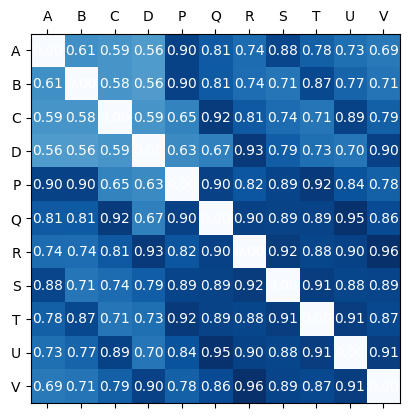

In [41]:
from itertools import combinations
from matplotlib import ticker

plt.rcParams.update({'font.size': 10})
plt.rc('xtick', labelsize=10)

cos = nn.CosineSimilarity(dim=0, eps=1e-6)

def get_param_vector(model):
    params = []
    for param in model.parameters():
        params.append(param.view(-1))
    params = torch.cat(params)
    return params

msp = ['A', 'B_perm_A', 'C_perm_P', 'D_perm_Q', 'P', 'Q', 'R', 'S', 'T', 'U', 'V']
ms = ['A', 'B', 'C', 'D', 'P', 'Q', 'R', 'S', 'T', 'U', 'V']
cs = np.zeros((len(ms),len(ms)))

model0 = NormMLP(h, layers).cuda()
model1 = NormMLP(h, layers).cuda()

for (i,j) in combinations(msp, r=2):
    load_model(model0, 'mlp_e50_l%d_h%d_%s' % (layers, h, i))
    load_model(model1, 'mlp_e50_l%d_h%d_%s' % (layers, h, j))

    r = cos(get_param_vector(model0), get_param_vector(model1)).detach().cpu().numpy()
    print(f'{i}, {j} --> cossim = {r}')
    cs[msp.index(i),msp.index(j)] = r
    cs[msp.index(j),msp.index(i)] = r

# print(cs)

fig, ax = plt.subplots()

ax.matshow(cs, cmap=plt.cm.Blues)
for i in range(len(ms)):
    for j in range(len(ms)):
        c = cs[j,i]
        ax.text(i, j, "{:.2f}".format(c), va='center', ha='center', color="w")

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xticks(range(len(ms)))
ax.set_yticks(range(len(ms)))
ax.set_xticklabels(ms)
ax.set_yticklabels(ms)
plt.show()

A, B_perm_A --> cossim = 0.9196517419815063
A, C_perm_P --> cossim = 0.9246204268932342
A, D_perm_Q --> cossim = 0.9151750195026398
A, P --> cossim = 0.9415664029121399
A, Q --> cossim = 0.9235629856586456
A, R --> cossim = 0.9137501680850982
A, S --> cossim = 0.9452574193477631
A, T --> cossim = 0.92220250248909
A, U --> cossim = 0.9164901304244996
A, V --> cossim = 0.9111381304264069
B_perm_A, C_perm_P --> cossim = 0.913960303068161
B_perm_A, D_perm_Q --> cossim = 0.9130850946903228
B_perm_A, P --> cossim = 0.9422846078872681
B_perm_A, Q --> cossim = 0.91577521443367
B_perm_A, R --> cossim = 0.9082224345207215
B_perm_A, S --> cossim = 0.903901777267456
B_perm_A, T --> cossim = 0.9436750268936157
B_perm_A, U --> cossim = 0.9153330898284913
B_perm_A, V --> cossim = 0.9101374173164367
C_perm_P, D_perm_Q --> cossim = 0.9148699915409089
C_perm_P, P --> cossim = 0.9084694588184357
C_perm_P, Q --> cossim = 0.9415726613998413
C_perm_P, R --> cossim = 0.9170602166652679
C_perm_P, S --> cossim

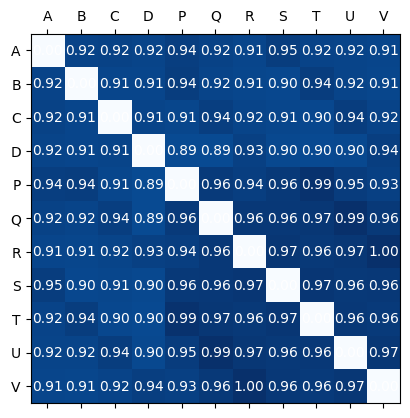

In [42]:
def calculate_CKA(kernel1, kernel2):
    n = kernel1.shape[0]
    H = (torch.eye(n) - 1 / n).to(device)
    kernel1_centered = torch.mm(torch.mm(H, kernel1), H).to(device)
    kernel2_centered = torch.mm(torch.mm(H, kernel2), H).to(device)

    # Compute the CKA
    cka = torch.trace(torch.mm(kernel1_centered, kernel2_centered)) \
          / torch.sqrt(torch.trace(torch.mm(kernel1_centered, kernel1_centered))) \
          / torch.sqrt(torch.trace(torch.mm(kernel2_centered, kernel2_centered)))

    return cka

def ckasim(model0, model1):
    cka_list = np.array([])

    for X, y in test_dataloader:
        X = X.to(device)

        with torch.no_grad():
            pred0 = model0(X).to(device)
            pred1 = model1(X).to(device)

            kernel1 = torch.mm(pred0, torch.t(pred0)).to(device)
            kernel2 = torch.mm(pred1, torch.t(pred1)).to(device)

            cka = calculate_CKA(kernel1, kernel2)
            cka_list = np.append(cka_list, cka.cpu().detach().numpy())

    return np.mean(cka_list)


from itertools import combinations
from matplotlib import ticker

cos = nn.CosineSimilarity(dim=0, eps=1e-6)

def get_param_vector(model):
    params = []
    for param in model.parameters():
        params.append(param.view(-1))
    params = torch.cat(params)
    return params

msp = ['A', 'B_perm_A', 'C_perm_P', 'D_perm_Q', 'P', 'Q', 'R', 'S', 'T', 'U', 'V']
ms = ['A', 'B', 'C', 'D', 'P', 'Q', 'R', 'S', 'T', 'U', 'V']
cs = np.zeros((len(ms),len(ms)))

model0 = NormMLP(h, layers).cuda()
model1 = NormMLP(h, layers).cuda()

for (i,j) in combinations(msp, r=2):
    load_model(model0, 'mlp_e50_l%d_h%d_%s' % (layers, h, i))
    load_model(model1, 'mlp_e50_l%d_h%d_%s' % (layers, h, j))

    r = ckasim(model0, model1)
    print(f'{i}, {j} --> cossim = {r}')
    cs[msp.index(i),msp.index(j)] = r
    cs[msp.index(j),msp.index(i)] = r

# print(cs)

fig, ax = plt.subplots()

ax.matshow(cs, cmap=plt.cm.Blues)
for i in range(len(ms)):
    for j in range(len(ms)):
        c = cs[j,i]
        ax.text(i, j, "{:.2f}".format(c), va='center', ha='center', color="w")

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xticks(range(len(ms)))
ax.set_yticks(range(len(ms)))
ax.set_xticklabels(ms)
ax.set_yticklabels(ms)
plt.show()